<img src="nag_logo.png" width=75px/>

# Financial debt compression exercise

## Prerequisites
In order to experiment and use this notebook, you will require to install the following packages: `numpy`, `networkx`, `matplotlib` and `naginterfaces`.


## Problem description
This notebook illustrates "Dept compression" through an illustrative example: after a year of weekly meetings at the pub, four friends all owe each other money and each of them would like to pay off its debt towards the others.

We'll represent the situation by a directed graph. For example, the statement "Tom owes £20.00 to Zoe" can be represented by the following Graph:

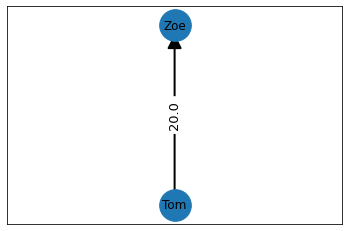

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Simple graph representing: "Tom owes 20£ to Zoe"
G = nx.DiGraph()
G.add_nodes_from(['Tom', 'Zoe'])
G.add_edge('Tom', 'Zoe', weight=20.0)
pos = nx.bipartite_layout(G, 'Zoe')
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size=1000)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True, width=2.0, arrowsize=30)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.5, font_size=13)
plt.show()

A the end of the year and after discussion, the group managed to summarize who the dept situation for each:

* Tom owes Zoe 30£
* Zoe owes David 55£ and John 15£
* David owes Tom 45£ and John 45£
* John owes Tom 35£

That is to say:

\begin{array}{rrrr}
~ & \text{Tom}  & \text{Zoe}  & \text{John}  & \text{David} \\
\text{Tom}  &  0 & -30 &  35 &  45 \\
\text{Zoe}  & 30 &   0 & -15 & -55 \\
\text{John} &-35 &  15 &   0 &  45 \\
\text{David}&-45 &  55 & -45 &   0 
\end{array}

We can store this information in the antisymmetric matrix $M$ where each row represents the amount of money owed by one member of the group to the others:
\begin{equation*}
M = 
\begin{pmatrix}
  0 & -30 & 35 & 45 \\
 30 & 0 & -15 & -55 \\
-35 & 15  & 0 & 45  \\
-45 & 55 & -45 & 0 
\end{pmatrix}
\end{equation*}
This can also be represented by the following graph:

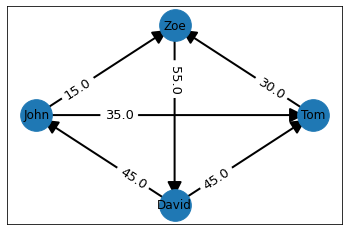

In [2]:
import numpy as np

def graph_from_matrix(mat, tol=1.0e-06):
    """
    Draw the debt graph from the upper triangular part of the debt matrix 
    """
    n = 4
    G = nx.DiGraph()
    names = ['Tom', 'Zoe', 'John', 'David']
    G.add_nodes_from(names)
    idx = 0
    for i in range(n-1):
        for j in range(i+1, n):
            if abs(mat[idx]) > tol:
                if mat[idx] < 0:
                    G.add_edge(names[i],names[j], weight=-round(mat[idx],3))
                else:
                    G.add_edge(names[j],names[i], weight=round(mat[idx],3))
            idx += 1
    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size=1000)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, arrows=True, width=2.0, arrowsize=30)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.7, font_size=13)
    plt.show()
    
# Full debt matrix and its upper triangular part
debts = np.array([[  0.0, -30.0,  35.0,  45.0],
                  [ 30.0,   0.0, -15.0, -55.0],
                  [-35.0,  15.0,   0.0,  45.0],
                  [-45.0,  55.0, -45.0,   0.0]])
upper_debts = np.array([-30., 35., 45., 15., -55., 45.])
graph_from_matrix(upper_debts)

The previous graph indicates that in order for each member to clear its debt:
 * John has to pay to Zoe £15, and to Tom £35
 * David has to pay John 45
 * and so forth
 
It is quite clear that all these payment transactions can be simplified or _compressed_. Take for example David, he needs to pay John £45 but also receives £45 from Tom, clearly it would be simpler if Tom pays directly John thus avoiding transacting twice.

The main question of this exercise is, can you find a debt payment strategy that has the least transaction and satisfies all the debts? Take for example this optimal solution:
<img src='optcompress.png'/>
only requires 3 payments and all debts are canceled! Note that missing arrows (edges) denote no transaction (payment) is necessary. So a payment strategy with the least edges and that clears all the debts is the winner.

Try using our optimization solvers to find this optimal solution!

The following questions will help you advance towards this goals.

## Questions

Without adding more money into the system, we want to simplify the payment strategy as much as possible. We consider two criteria:
1. The sum of squares of all the individual debts should be as small as possible (2-norm):

In [3]:
print("Current sum of squares of the debts: {:.2f}".format(sum(np.square(upper_debts))))

Current sum of squares of the debts: 9425.00


2. The total amounts of debts is as small as possible (1-norm):

In [4]:
print("Current total amount of debts: {:.2f}".format(sum(abs(upper_debts))))

Current total amount of debts: 225.00


<div class="alert alert-block alert-success">
    <b>Tip</b> 2-Norm solutions find payment strategies where each transaction amount is as *small* as possible, 
    while 1-norm solution find payment strategies where the number of transaction is the *fewest* possible.
</div>

For both questions, you should present your solution in the form of an update of the upper triangular debt matrix shown above. The utility functions `check_solution()` and `graph_from_matrix()` are provided to visualize your solution and check its validity.

In [5]:
def check_solution(sol, tol=1.0e-06):
    nvar = 6
    n = 4
    if len(sol) > 6:
        return False
    expo = n*[0.0]
    idx = 0
    for i in range(n-1):
        for j in range(i+1, n):
            expo[i] += sol[idx]
            expo[j] -= sol[idx]
            idx += 1
    comp = [50., -10., -5., -35.]
    if any([abs(comp[i]-expo[i]) > tol for i in range(n)]):
        return False
    return True

The vector provided is a solution: True


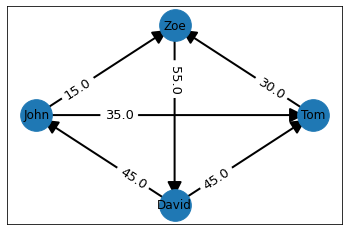

In [6]:
from naginterfaces.library import opt
from naginterfaces.base import utils 

# Write your solution here, upper_debts is the initial debt for all the friends
solution = upper_debts

# TO DO: Code you solution here!
# once you have found a solution save it in "solution"
# solution = ...

print("The vector provided is a solution: {sol}".format(sol = check_solution(solution)))
graph_from_matrix(solution)

## References

This exercise is actually a simple instance of the very common portfolio compression problem encountered by banks and insurers at a much larger scale. A nice introduction to this problem can be found here (try to solve the exercise before reading)

[<a id="cit">1</a>] O'Kane D., *Optimising the multilateral netting of fungible OTC derivatives*, Quantitative Finance, vol. 17, 2017.

## Tips

<div class="alert alert-block alert-success">
    <b>Tip</b> 2-Norm solutions can be found using solvers such as QP or SOCP, look into the documentation for <code>handle_solve_socp_ipm</code>. Also look for a equivalent reformulation of the squared 2-norm, $\|x\|^2_2$...
</div>

<div class="alert alert-block alert-success">
    <b>Tip</b> 1-Norm solution, 
    $\min\, |x|$, can be thought has a group of box or bound constraints along with the debt constraints, this forms a Linear Program (LP), look into the documentation Introduction for Chapter E04 for more information related to LP.
</div>

# Send us your solution notebook!
You have until the end of the trial licence to update this notebook with your solution! 
Once you have it solved, send your notebook to [andrew.sajo@nag.co.uk](mailto:andrew.sajo@nag.co.uk)! You are also welcome to also ask for further tips.